In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from jinja2.optimizer import optimize
from keras import layers
from numpy.f2py.rules import options
from tensorflow.keras.applications import EfficientNetB0

2025-03-30 11:54:13.880036: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 11:54:14.227266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743332054.350263    1258 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743332054.385272    1258 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743332054.695080    1258 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
image_size = 224
batch_size = 32

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(dataset_name,
                                         split=["train", "test"],
                                         with_info=True,
                                         as_supervised=True)
NUM_CLASSES = ds_info.features['label'].num_classes

I0000 00:00:1743332058.402382    1258 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
size = (image_size, image_size)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))



2025-03-30 11:54:19.055828: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-30 11:54:19.251234: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


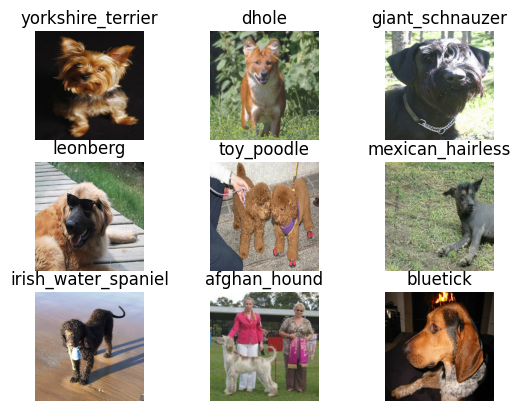

In [4]:
def format_image(label):
    return label_info.int2str(label).split('-')[1]

label_info = ds_info.features['label']

for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title("{}".format(format_image(label)))
    plt.axis('off')




In [5]:
img_augmentatiom_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

def img_augmentation(images):
    for aug in img_augmentatiom_layers:
        images = aug(images)
    return images

2025-03-30 11:54:21.510941: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


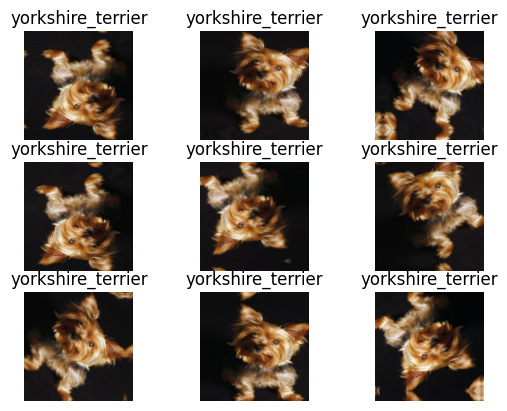

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_image = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_image = np.array(aug_image)
        plt.imshow(aug_image[0].astype('uint8'))
        plt.title("{}".format(format_image(label)))
        plt.axis('off')

In [7]:
def input_prepeocess_train(image, label):
    return img_augmentation(image), tf.one_hot(label, NUM_CLASSES)

def input_prepeocess_test(image, label):
    return image, tf.one_hot(label, NUM_CLASSES)


ds_train = ds_train.map(input_prepeocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_prepeocess_test, num_parallel_calls = tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [8]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(image_size, image_size, 3),
)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:
epochs = 40
hist = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
)

Epoch 1/40


I0000 00:00:1743332075.844880    1714 service.cc:152] XLA service 0x55a526866030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743332075.844916    1714 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-30 11:54:36.366978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743332078.574556    1714 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1743332103.352397    1714 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.0105 - loss: 5.0662

2025-03-30 11:55:42.376512: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 244 bytes spill stores, 244 bytes spill loads

2025-03-30 11:55:42.398593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068_0', 328 bytes spill stores, 980 bytes spill loads

2025-03-30 11:55:42.704964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 5336 bytes spill stores, 5356 bytes spill loads

2025-03-30 11:55:42.803386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2068', 5280 bytes spill stores, 5244 bytes spill loads



375/375 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.0105 - loss: 5.0658 - val_accuracy: 0.0113 - val_loss: 4.9221
Epoch 2/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.0204 - loss: 4.6674 - val_accuracy: 0.0191 - val_loss: 4.7091
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.0295 - loss: 4.4514 - val_accuracy: 0.0420 - val_loss: 4.4202
Epoch 4/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 113ms/step - accuracy: 0.0453 - loss: 4.2993 - val_accuracy: 0.0395 - val_loss: 4.3738
Epoch 5/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 109ms/step - accuracy: 0.0581 - loss: 4.1772 - val_accuracy: 0.0570 - val_loss: 4.1334
Epoch 6/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.0635 - loss: 4.0902 - val_accuracy: 0.0632 - val_loss: 4.0820
Epoch 7/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 113ms/step - accuracy: 0.0765 - loss: 4.0009 - val_accuracy: 0.0624 - val_loss: 4.1260
Epoch 8/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - accuracy: 0.0875 - loss: 3.9308 - val

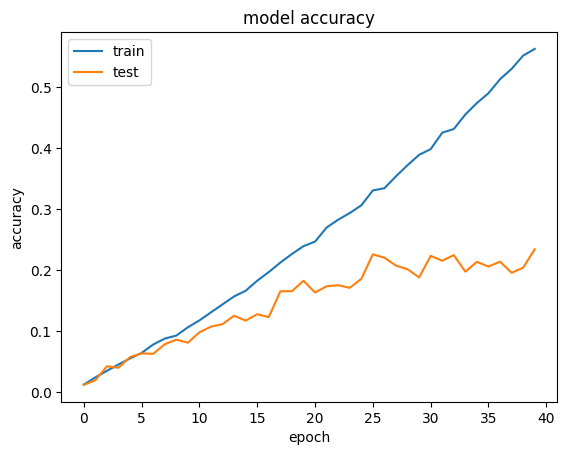

In [10]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_hist(hist)

Epoch 1/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 73s 121ms/step - accuracy: 0.5882 - loss: 1.4167 - val_accuracy: 0.2154 - val_loss: 4.1612
Epoch 2/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.6234 - loss: 1.2722 - val_accuracy: 0.2183 - val_loss: 4.3384
Epoch 3/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 42s 111ms/step - accuracy: 0.6475 - loss: 1.1820 - val_accuracy: 0.2250 - val_loss: 4.4054
Epoch 4/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 110ms/step - accuracy: 0.6533 - loss: 1.1671 - val_accuracy: 0.2181 - val_loss: 4.4728


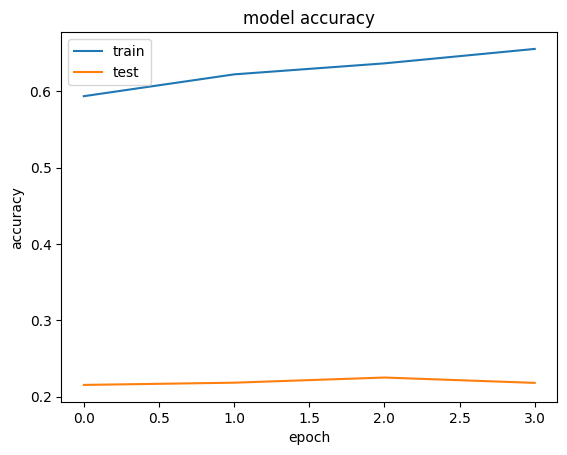

In [15]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

unfreeze_model(model)
epochs = 4
hist = model.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_test,
)
plot_hist(hist)